### 1 ) 라이브러리 호출

In [1]:
import pandas as pd
import konlpy
import gensim
import re

### 2 ) 데이터 호출 및 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

### 데이터로더 구성

In [4]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### NaN 결측치 제거 및 중복 값 제거

In [5]:
def preprocess_(dataset):
    dataset.drop(dataset[dataset['document'].duplicated()].index.values, inplace=True)
    dataset.drop(dataset[dataset['document'].isnull()].index.values, inplace=True)

In [6]:
preprocess_(train_data)

In [7]:
preprocess_(test_data)

In [8]:
train_data.shape, test_data.shape

((146182, 3), (49157, 3))

#### 특수기호 및 공백 제거

In [9]:
train_data['document'] = train_data['document'].str.replace(pat=r'[^ㄱ-ㅎ|가-힣|a-z|A-Z|0-9]', repl=r' ', regex=True)
train_data['document'] = train_data['document'].str.replace(pat=r' +', repl=r' ', regex=True)

In [10]:
train_data['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                              흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                교도소 이야기구먼 솔직히 재미는 없다 평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                     인간이 문제지 소는 뭔죄인가 
149996                                          평점이 너무 낮아서 
149997                       이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다 
149998                          청춘 영화의 최고봉 방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [11]:
train_data['document'][0]

'아 더빙 진짜 짜증나네요 목소리'

In [12]:
test_data['document'] = test_data['document'].str.replace(pat=r'[^ㄱ-ㅎ|가-힣|a-z|A-Z|0-9]', repl=r' ', regex=True)
test_data['document'] = test_data['document'].str.replace(pat=r' +', repl=r' ', regex=True)

In [13]:
test_data['document'][0]

'굳 ㅋ'

#### 사전 구성

In [14]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [15]:
for idx, x in enumerate(X_train):
    X_train[idx] = [1] + X_train[idx]

for idx, x in enumerate(X_test):
    X_test[idx] = [1] + X_test[idx]

In [16]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

In [17]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
index_to_word[1]

'<BOS>'

In [19]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 진짜 짜증 나 네요 목소리
라벨:  0


In [20]:
X_train[0]

[1, 27, 68, 912, 34, 216, 15, 28, 713]

In [21]:
print(get_decoded_sentence(X_train[1], index_to_word))
print('라벨: ', y_train[1])  # 1번째 리뷰데이터의 라벨

흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나
라벨:  1


### 3 ) 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [22]:
import matplotlib.pyplot as plt

In [23]:
len_x = [len(x) for x in X_train]

(array([5.6288e+04, 5.1996e+04, 1.9533e+04, 6.5540e+03, 4.3660e+03,
        4.0490e+03, 2.7460e+03, 5.8300e+02, 5.8000e+01, 9.0000e+00]),
 array([ 1. ,  9.4, 17.8, 26.2, 34.6, 43. , 51.4, 59.8, 68.2, 76.6, 85. ]),
 <BarContainer object of 10 artists>)

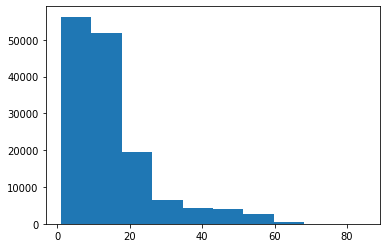

In [24]:
plt.hist(len_x)

In [25]:
np.histogram(len_x)

(array([56288, 51996, 19533,  6554,  4366,  4049,  2746,   583,    58,
            9]),
 array([ 1. ,  9.4, 17.8, 26.2, 34.6, 43. , 51.4, 59.8, 68.2, 76.6, 85. ]))

### 데이터셋 내 문장 길이가 38이하인 경우가 93%. 따라서 최대 길이를 38로 지정한다.

In [26]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.995003557917261
문장길이 최대 :  106
문장길이 표준편차 :  11.633012986583513
pad_sequences maxlen :  38
전체 문장의 0.935363649859987%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
import tensorflow as tf

In [28]:
vocab_size = len(word_to_index) 
word_vector_dim = 38

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 38)


### 4 ) 모델 구성 및 validation set 구성 5 ) 모델 훈련 개시 6) Loss, Accuracy 그래프 시각화

#### 1 ) 모델 1. 512, 256, 1

In [29]:
vocab_size = len(word_to_index)
word_vector_dim = 38

tf.random.set_seed(2022)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(38))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 38)          380038    
_________________________________________________________________
lstm (LSTM)                  (None, 38)                11704     
_________________________________________________________________
dropout (Dropout)            (None, 38)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               19968     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [30]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 38)
(136182,)


In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
266/266 [==============================] - 5s 8ms/step - loss: 0.6927 - accuracy: 0.5590 - val_loss: 0.6914 - val_accuracy: 0.6065
Epoch 2/50
266/266 [==============================] - 2s 7ms/step - loss: 0.6867 - accuracy: 0.6481 - val_loss: 0.6774 - val_accuracy: 0.6886
Epoch 3/50
266/266 [==============================] - 2s 7ms/step - loss: 0.6556 - accuracy: 0.7217 - val_loss: 0.6226 - val_accuracy: 0.7468
Epoch 4/50
266/266 [==============================] - 2s 6ms/step - loss: 0.5769 - accuracy: 0.7681 - val_loss: 0.5257 - val_accuracy: 0.7843
Epoch 5/50
266/266 [==============================] - 2s 6ms/step - loss: 0.4872 - accuracy: 0.7924 - val_loss: 0.4546 - val_accuracy: 0.8019
Epoch 6/50
266/266 [==============================] - 2s 6ms/step - loss: 0.4375 - accuracy: 0.8082 - val_loss: 0.4224 - val_accuracy: 0.8157
Epoch 7/50
266/266 [==============================] - 2s 6ms/step - loss: 0.4129 - accuracy: 0.8188 - val_loss: 0.4049 - val_accuracy: 0.8219
Epoch 

In [32]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3675 - accuracy: 0.8421
[0.36752063035964966, 0.8421180844306946]


In [33]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


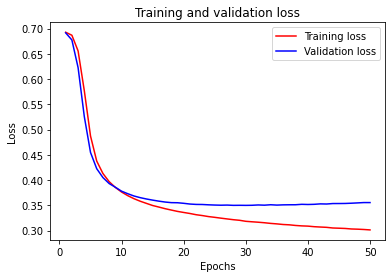

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

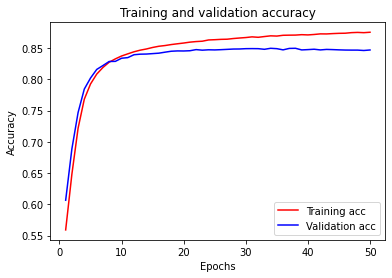

In [35]:
plt.clf()

plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 2 ) 모델 2. 256, 128, 1

In [36]:
vocab_size = len(word_to_index)
word_vector_dim = 38

tf.random.set_seed(2022)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(38))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 38)          380038    
_________________________________________________________________
lstm_1 (LSTM)                (None, 38)                11704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               9984      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [37]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 38)
(136182,)


In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
266/266 [==============================] - 4s 8ms/step - loss: 0.6928 - accuracy: 0.5528 - val_loss: 0.6920 - val_accuracy: 0.6050
Epoch 2/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6897 - accuracy: 0.6375 - val_loss: 0.6854 - val_accuracy: 0.6765
Epoch 3/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6768 - accuracy: 0.7088 - val_loss: 0.6632 - val_accuracy: 0.7362
Epoch 4/50
266/266 [==============================] - 2s 7ms/step - loss: 0.6409 - accuracy: 0.7555 - val_loss: 0.6106 - val_accuracy: 0.7717
Epoch 5/50
266/266 [==============================] - 2s 7ms/step - loss: 0.5727 - accuracy: 0.7844 - val_loss: 0.5304 - val_accuracy: 0.7919
Epoch 6/50
266/266 [==============================] - 2s 7ms/step - loss: 0.4969 - accuracy: 0.8000 - val_loss: 0.4662 - val_accuracy: 0.8081
Epoch 7/50
266/266 [==============================] - 2s 7ms/step - loss: 0.4494 - accuracy: 0.8104 - val_loss: 0.4345 - val_accuracy: 0.8154
Epoch 

In [39]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3641 - accuracy: 0.8433
[0.36410388350486755, 0.8433183431625366]


In [40]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


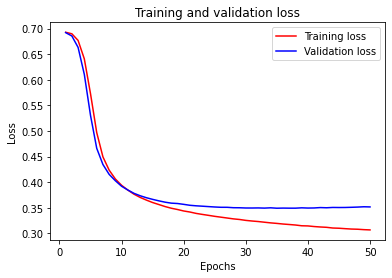

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

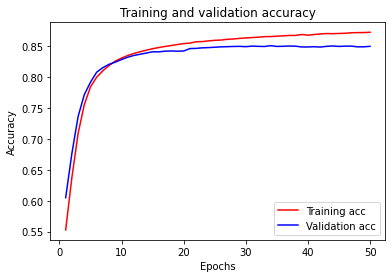

In [42]:
plt.clf()   

plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3 ) 모델 3. 128, 64, 1

In [43]:
vocab_size = len(word_to_index)
word_vector_dim = 38

tf.random.set_seed(2022)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(38))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 38)          380038    
_________________________________________________________________
lstm_2 (LSTM)                (None, 38)                11704     
_________________________________________________________________
dropout_4 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4992      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [44]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 38)
(136182,)


In [45]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
266/266 [==============================] - 3s 7ms/step - loss: 0.6930 - accuracy: 0.5074 - val_loss: 0.6927 - val_accuracy: 0.5222
Epoch 2/50
266/266 [==============================] - 2s 7ms/step - loss: 0.6919 - accuracy: 0.5269 - val_loss: 0.6904 - val_accuracy: 0.5638
Epoch 3/50
266/266 [==============================] - 2s 7ms/step - loss: 0.6877 - accuracy: 0.6006 - val_loss: 0.6829 - val_accuracy: 0.6470
Epoch 4/50
266/266 [==============================] - 2s 7ms/step - loss: 0.6761 - accuracy: 0.6803 - val_loss: 0.6651 - val_accuracy: 0.7085
Epoch 5/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6508 - accuracy: 0.7347 - val_loss: 0.6301 - val_accuracy: 0.7455
Epoch 6/50
266/266 [==============================] - 2s 6ms/step - loss: 0.6070 - accuracy: 0.7689 - val_loss: 0.5781 - val_accuracy: 0.7847
Epoch 7/50
266/266 [==============================] - 2s 6ms/step - loss: 0.5558 - accuracy: 0.7896 - val_loss: 0.5312 - val_accuracy: 0.8003
Epoch 

In [46]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3625 - accuracy: 0.8443
[0.3624567985534668, 0.8443354964256287]


In [47]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


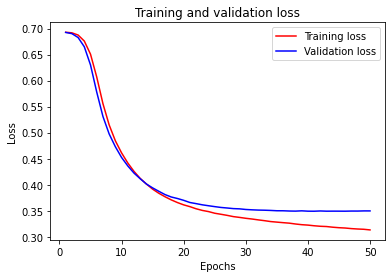

In [48]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

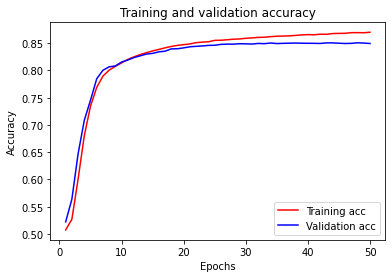

In [49]:
plt.clf()

plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7 ) 학습된 Embedding 레이어 분석

In [50]:
import os

In [51]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10001, 38)


In [52]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
vocab_size = 10000
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [54]:
word_to_index

{'': 3,
 '영화': 4,
 '다': 5,
 '고': 6,
 '하': 7,
 '을': 8,
 '보': 9,
 '게': 10,
 '지': 11,
 '있': 12,
 '없': 13,
 '좋': 14,
 '나': 15,
 '었': 16,
 '만': 17,
 '는데': 18,
 '너무': 19,
 '봤': 20,
 '적': 21,
 '안': 22,
 '정말': 23,
 '로': 24,
 '음': 25,
 '것': 26,
 '아': 27,
 '네요': 28,
 '재밌': 29,
 '어': 30,
 '지만': 31,
 '같': 32,
 '점': 33,
 '진짜': 34,
 '에서': 35,
 '했': 36,
 '기': 37,
 '네': 38,
 '않': 39,
 '거': 40,
 '았': 41,
 '수': 42,
 '되': 43,
 '면': 44,
 'ㅋㅋ': 45,
 '인': 46,
 '말': 47,
 '연기': 48,
 '주': 49,
 '내': 50,
 '최고': 51,
 '평점': 52,
 '이런': 53,
 '던': 54,
 '어요': 55,
 '할': 56,
 '왜': 57,
 '겠': 58,
 '1': 59,
 '스토리': 60,
 '해': 61,
 '습니다': 62,
 'ㅋㅋㅋ': 63,
 '듯': 64,
 '아니': 65,
 '드라마': 66,
 '생각': 67,
 '더': 68,
 '그': 69,
 '싶': 70,
 '사람': 71,
 '감동': 72,
 '때': 73,
 '배우': 74,
 '함': 75,
 '본': 76,
 '까지': 77,
 '뭐': 78,
 '알': 79,
 '만들': 80,
 '내용': 81,
 '볼': 82,
 '보다': 83,
 '라': 84,
 '감독': 85,
 '재미': 86,
 '그냥': 87,
 '시간': 88,
 '중': 89,
 '지루': 90,
 '재미있': 91,
 '년': 92,
 '10': 93,
 '였': 94,
 '잼': 95,
 '사랑': 96,
 '못': 97,
 '냐': 98,
 '재미없':

In [55]:
vector = word_vectors['영화']
vector

array([ 1.87586527e-02, -2.91616861e-02, -2.00320296e-02,  4.80549224e-02,
       -4.64905612e-02,  1.82736512e-05,  3.07295527e-02, -3.74986231e-03,
        1.82349682e-02,  3.57452035e-02, -4.38800901e-02,  2.67890487e-02,
       -3.25750932e-02,  2.52633654e-02,  1.16334716e-02, -2.47889776e-02,
       -1.72875694e-03, -1.64814778e-02,  2.10837536e-02, -3.83780501e-03,
        4.78179045e-02, -2.54159663e-02, -2.98091080e-02, -5.18589765e-02,
        3.48485559e-02,  1.46036185e-02, -3.03494520e-02,  1.35493930e-02,
        3.24948840e-02, -9.30166524e-03, -4.08736020e-02, -4.11469415e-02,
       -1.66952182e-02,  5.84030943e-03, -1.48667470e-02,  9.59829427e-04,
       -3.39156725e-02,  2.25021746e-02], dtype=float32)

In [56]:
word_vectors.similar_by_word("영화")

[('심은하', 0.6053353548049927),
 ('차원', 0.559093713760376),
 ('간다고', 0.5295854210853577),
 ('거늘', 0.5033552050590515),
 ('메기', 0.4922638237476349),
 ('장소', 0.48905104398727417),
 ('넘길', 0.48435238003730774),
 ('으으으', 0.48420578241348267),
 ('탄생', 0.4786781668663025),
 ('마라', 0.473793625831604)]

In [57]:
word_vectors.similar_by_word("참신")

[('적어도', 0.6218013763427734),
 ('섬세', 0.6073476672172546),
 ('정점', 0.5957375168800354),
 ('편도', 0.591017484664917),
 ('평온', 0.5794827938079834),
 ('경이', 0.5695465803146362),
 ('흥미진진', 0.5666174292564392),
 ('한동안', 0.5598949193954468),
 ('최소', 0.5581011176109314),
 ('재발견', 0.5571665167808533)]

In [58]:
word_vectors.similar_by_word("호러")

[('힙', 0.6319668889045715),
 ('끼리', 0.6080080270767212),
 ('싱겁', 0.5846025347709656),
 ('뽀로로', 0.55429607629776),
 ('죽도', 0.5469654202461243),
 ('김정훈', 0.541936993598938),
 ('멀', 0.530286967754364),
 ('앉', 0.5281303524971008),
 ('거슬린다', 0.522792637348175),
 ('저질', 0.5226380228996277)]

### 8 ) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [59]:
import os

In [60]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors(vector_size=38).load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [61]:
word_vector_dim = 100 
embedding_matrix = np.random.rand(10000, word_vector_dim)
for i in range(4,10000):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [62]:
vocab_size = len(word_to_index)
word_vector_dim = 38

tf.random.set_seed(2022)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(38))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 38)          380038    
_________________________________________________________________
lstm_3 (LSTM)                (None, 38)                11704     
_________________________________________________________________
dropout_6 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4992      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [63]:
from tensorflow.keras.initializers import Constant

In [64]:
embedding_matrix.shape

(10000, 100)

In [65]:
vocab_size = len(word_to_index)
word_vector_dim = 38

tf.random.set_seed(2022)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(10000, 100, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(38))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 38, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 38)                21128     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2496      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 1,023,689
Trainable params: 1,023,689
Non-trainable params: 0
_________________________________________________________________


In [66]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 38)
(136182,)


In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=45  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/45
266/266 [==============================] - 4s 8ms/step - loss: 0.6505 - accuracy: 0.6201 - val_loss: 0.5909 - val_accuracy: 0.6988
Epoch 2/45
266/266 [==============================] - 2s 6ms/step - loss: 0.5499 - accuracy: 0.7252 - val_loss: 0.5082 - val_accuracy: 0.7554
Epoch 3/45
266/266 [==============================] - 2s 6ms/step - loss: 0.4970 - accuracy: 0.7618 - val_loss: 0.4734 - val_accuracy: 0.7789
Epoch 4/45
266/266 [==============================] - 2s 6ms/step - loss: 0.4673 - accuracy: 0.7817 - val_loss: 0.4509 - val_accuracy: 0.7906
Epoch 5/45
266/266 [==============================] - 2s 7ms/step - loss: 0.4454 - accuracy: 0.7947 - val_loss: 0.4331 - val_accuracy: 0.7997
Epoch 6/45
266/266 [==============================] - 2s 7ms/step - loss: 0.4299 - accuracy: 0.8048 - val_loss: 0.4187 - val_accuracy: 0.8080
Epoch 7/45
266/266 [==============================] - 2s 6ms/step - loss: 0.4153 - accuracy: 0.8124 - val_loss: 0.4068 - val_accuracy: 0.8157
Epoch 

In [68]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3519 - accuracy: 0.8525
[0.35187575221061707, 0.8525133728981018]


In [69]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


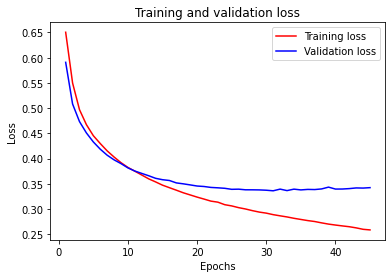

In [70]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

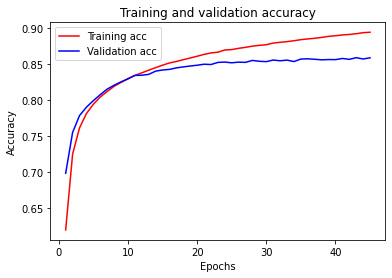

In [71]:
plt.clf()

plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 9 ) 회고

#### NLP는 전처리 과정이 꽤나 많이 존재하고, 성능이 이에 상당히 의존하는 듯 보였다. 따라서, NLP 임베딩과정에 대해서 더욱 공부해 볼 계획이다.

#### Mecab을 사용했을 때, '더빙'이라는 단어가 '더'와 '빙'으로 나뉘었다. 물론 모든 단어를 커버할 순 없겠지만, 약간의 아쉬움이 있었고, 다른 토크나이저의 종류를 찾아보고 내 데이터셋에 알맞은 토크나이저를 선택하는 것이 중요한 것 같다.